# Strategies

This notebook aims to test a neural network using different word embedding methods.

**Word embedding methods:**

| Method       | Definition                                                                 | Advantages                                                                                     | Limitations                                                                 |
|--------------|-----------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| Word2Vec     | Represents words as dense vectors in a continuous space, capturing semantic relationships based on context. | Effective for capturing semantic relationships; widely used in NLP tasks.                     | Requires large datasets; struggles with out-of-vocabulary words.            |
| Glove        | Generates word embeddings by factorizing a co-occurrence matrix, capturing both local and global semantic relationships. | Captures both local and global context; effective for text classification and sentiment analysis. | Computationally expensive; requires pre-computed co-occurrence statistics.  |
| USE (Universal Sentence Encoder) | Produces embeddings for entire sentences rather than individual words, leveraging deep learning models. | Captures sentence-level semantics; pre-trained models available for quick use.                | Higher computational cost; less effective for word-level tasks.             |
| BERT | Bidirectional Encoder Representations from Transformers; contextual word embeddings that consider the entire context of a word from both directions. | Superior contextual understanding; pre-trained on massive datasets; captures complex language patterns. | Computationally expensive; requires significant memory; longer training times than traditional methods. |

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import warnings
from collections import Counter
import pickle
from tqdm import tqdm

# NLTK
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, make_scorer, matthews_corrcoef, balanced_accuracy_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)


import numpy as np

import mlflow
import mlflow.keras


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

# Data preparation

## Import

In [3]:
path_to_sample = "../data/processed_sample_tweets.csv"

sample_df = pd.read_csv(path_to_sample, encoding='utf-8')
# Display the first few rows of the dataframe
sample_df.head(10)

,target,ids,date,user,text,processed_text_lem,advanced_processed_text_lem,processed_text_stem,advanced_processed_text_stem
0,0,2065378704,2009-06-07 08:28:25,juliaindelicate,@christt I really wanted to go i didn't get t...,< mention > really wanted go not get go anal b...,< mention > really wanted go not get go anal b...,< mention > realli want go not get go ani anal...,< mention > realli want go not get go ani anal...
1,0,2198776518,2009-06-16 16:33:19,hxcfairy,Finally home from my sisters and I'm so tired,finally home sister tired,finally home sister tired,final home sister tire,final home sister tire
2,0,2258118867,2009-06-20 15:24:59,TranceGemini613,"I really, really wish I'd known all the stuff ...",really really wish would known stuff james tel...,really really wish would known stuff james tel...,realli realli wish would known stuff jame tell...,realli realli wish would known stuff jame tell...
3,0,1755733793,2009-05-10 09:53:26,jwatkins5377,Can officially say I have been at work EVERYDA...,officially say work everyday week ... bad toda...,officially say work everyday week ... bad toda...,offici say work everyday thi week ... bad toda...,offici say work everyday thi week ... bad toda...
4,0,1881082418,2009-05-22 03:32:26,davelee,#FirstRecord The Mr Blobby single Sorry folks.,< hashtag > mr blobby single sorry folk .,< hashtag > mr lobby single sorry folk .,< hashtag > mr blobbi singl sorri folk .,< hashtag > mr lobbi singl sorri folk .
5,0,2045678642,2009-06-05 11:04:38,johnny101,My turkey and ham salad wrap is not sitting we...,turkey ham salad wrap not sitting well .,turkey ham salad wrap not sitting well .,turkey ham salad wrap not sit well .,turkey ham salad wrap not sit well .
6,0,2323712552,2009-06-25 01:17:50,Matt_Whiting,Footy Trainin Was called off Now i Dont kn...,footy trainin wa called dont know ? laugh loud,footy training wa called not know ? lot,footi trainin wa call dont know ? laugh loud,footi train wa call not know ? lot
7,0,2200119346,2009-06-16 18:27:54,JoePaley17,Just got bacl from ftbl summer school tomorrow,got bacl ftbl summer school tomorrow,got back feel summer school tomorrow,got bacl ftbl summer school tomorrow,got back feel summer school tomorrow
8,0,2247872282,2009-06-19 19:45:15,trexsandwich,"@writesfortea Cool teachers are the best, but ...",< mention > cool teacher best never lasted sch...,< mention > cool teacher best never lasted sch...,< mention > cool teacher best never last schoo...,< mention > cool teacher best never last schoo...
9,0,1835988160,2009-05-18 07:09:13,renzzee,"@rediska08 awts. friday, parteeey! hahaha! sa...",< mention > awts . friday parteey ! hahaha ! s...,< mention > awts . friday parteey ! hahaha ! s...,< mention > awt . friday parteey ! hahaha ! sa...,< mention > awt . friday parteey ! hahaha ! sa...


## MLFlow setup

In [6]:
import os
from dotenv import load_dotenv
import time

import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient


from tqdm import tqdm


# For scikit-learn
mlflow.sklearn.autolog()

# Configuring MLflow
load_dotenv()
tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(tracking_uri)
print(f"MLflow Tracking URI: {tracking_uri}")

MLflow Tracking URI: http://localhost:8081


In [7]:
# Create a new MLflow Experiment
experiment_name = "P7-Sentiments_Analysis_neural_network"

# Check if the experiment exists, create it if it doesn't
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment '{experiment_name}' with ID: {experiment_id}")
else:
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment '{experiment_name}' with ID: {experiment_id}")

# Set the experiment
mlflow.set_experiment(experiment_name)

Using existing experiment 'P7-Sentiments_Analysis_neural_network' with ID: 859618380264734882


<Experiment: artifact_location='mlflow-artifacts:/859618380264734882', creation_time=1760707139984, experiment_id='859618380264734882', last_update_time=1760707139984, lifecycle_stage='active', name='P7-Sentiments_Analysis_neural_network', tags={}>

# Functions

In [20]:
def log_metrics_summary_table(metrics, dataset_type, embedding_type):
    """
    Creates and logs a detailed metrics summary table as a CSV file.

    Args:
        metrics: Dictionary of evaluation metrics
        dataset_type: 'validation' or 'test'
        embedding_type: Type of embedding used (w2v, fasttext, glove)
    """
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame([metrics])

    # Add embedding type and dataset information
    metrics_df['embedding'] = embedding_type
    metrics_df['dataset'] = dataset_type

    # Save as CSV
    csv_path = f"../data/{dataset_type}_metrics_{embedding_type}.csv"
    metrics_df.to_csv(csv_path, index=False)

    # Log to MLflow
    mlflow.log_artifact(csv_path, artifact_path="metrics_summaries")

    return metrics_df

## Classes

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


print("Version:", tf.__version__)
print("GPU disponible :", tf.config.list_physical_devices('GPU'))


Version: 2.16.2
GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from gensim.models import Word2Vec, FastText
import os

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

class NeuralTweetClassifier:
    """
        A classifier that uses neural networks (LSTM, RNN, Bidirectional LSTM) with
        different word embeddings (Word2Vec, FastText, GloVe) to classify tweets.
    """
    def __init__(self, embedding:str, embedding_dim: int=100, lstm_units: int=128,
                max_length: int=100, model_type: str='LSTM', base_dir: str = "../"):
        """
            Initialize the NeuralTweetClassifier.

            Args:
                embedding (str): Type of embedding to use ('w2v', 'fasttext', 'glove')
                embedding_dim (int): Dimension of the embedding vectors
                lstm_units (int): Number of units in the LSTM/RNN layers
                max_length (int): Maximum length of input sequences
                model_type (str): Type of model to use ('LSTM', 'RNN', 'Bidirectional_LSTM')
                base_dir (str): Base directory for saving artifacts
        """
        self.embedding = embedding
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.max_length = max_length
        self.tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
        self.model_type = model_type
        self.model = None

        # Directory structure
        self.base_dir = base_dir
        self.artifacts_dir = os.path.join(self.base_dir, "artifacts")
        self.models_dir = os.path.join(self.base_dir, "models")
        self.checkpoints_dir = os.path.join(self.base_dir, "checkpoints")

        # Create directories if they don't exist
        for directory in [self.artifacts_dir, self.models_dir, self.checkpoints_dir]:
            os.makedirs(directory, exist_ok=True)

        # Validate inputs
        valid_model_types = ['LSTM', 'RNN', 'Bidirectional_LSTM', 'GRU', 'Bidirectional_GRU']
        valid_embeddings = ['w2v', 'fasttext', 'glove']

        if model_type not in valid_model_types:
            raise ValueError(f"model_type must be one of {valid_model_types}")
        if embedding not in valid_embeddings:
            raise ValueError(f"embedding must be one of {valid_embeddings}")

    # === TOKENIZER ===
    def fit_tokenizer(self, texts: pd.Series):
        """
        Fits the tokenizer on the input texts and returns padded sequences.

        Args:
            texts (pd.Series): Series of text strings to tokenize

        Returns:
            np.ndarray: Padded sequences of token IDs
        """
        # Tokenize texts
        self.tokenizer.fit_on_texts(texts)
        # Convert texts to sequences
        sequences = self.tokenizer.texts_to_sequences(texts)
        # Uniform length by padding/truncating
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        return padded_sequences

    # === EMBEDDING ===
    def build_embedding_matrix(self, texts: pd.Series):
        """
        Builds embedding matrix for the tokenized vocabulary.

        Args:
            texts (pd.Series): Series of text strings to build embeddings for

        Returns:
            np.ndarray: Embedding matrix with shape (vocab_size, embedding_dim)
        """
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))

        sentences = texts.tolist()

        if self.embedding == 'w2v':
            model = Word2Vec(sentences=[s.split() for s in sentences], vector_size=self.embedding_dim, window=5, min_count=1, workers=4)
            has_wv_attr = True
        elif self.embedding == 'fasttext':
            model = FastText(sentences=[s.split() for s in sentences], vector_size=self.embedding_dim, window=5, min_count=1, workers=4)
            has_wv_attr = True
        elif self.embedding == 'glove':
            import gensim.downloader as api
            model = api.load("glove-twitter-100")
            has_wv_attr = False
        else:
            raise ValueError("Unsupported embedding type. Choose 'w2v', 'fasttext', or 'glove'.")

        # Fill embedding matrix with word vectors
        for word, i in word_index.items():
            if has_wv_attr and word in model.wv:
                embedding_matrix[i] = model.wv[word]
            elif not has_wv_attr and word in model:
                embedding_matrix[i] = model[word]

        return embedding_matrix

    # === MODEL ===
    def build_model(self, vocab_size: int, embedding_matrix: np.ndarray):
        """
        Builds neural network model with the specified architecture.

        Args:
            vocab_size (int): Size of the vocabulary
            embedding_matrix (np.ndarray): Pre-built embedding matrix

        Returns:
            keras.Model: Built model
        """
        self.model = Sequential()
        self.model.add(Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, weights=[embedding_matrix], input_length=100, trainable=True))

        if self.model_type == 'RNN':
            self.model.add(SimpleRNN(self.lstm_units, return_sequences=False, dropout=0.3))


        elif self.model_type == 'LSTM':
            self.model.add(LSTM(self.lstm_units, return_sequences=False, dropout=0.3))

        elif self.model_type == 'Bidirectional_LSTM':
            self.model.add(Bidirectional(LSTM(self.lstm_units, return_sequences=False, dropout=0.3)))

        elif self.model_type == 'GRU':
            self.model.add(GRU(self.lstm_units, return_sequences=False, dropout=0.3))

        elif self.model_type == 'Bidirectional_GRU':
            self.model.add(Bidirectional(GRU(self.lstm_units, return_sequences=False, dropout=0.3)))


        self.model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

        return self.model

    # === METRICS ===
    def compute_metrics(self, y_true, y_pred, prefix=""):
        """
        Calculates and returns various classification metrics.

        Args:
            y_true (np.ndarray): True labels
            y_pred (np.ndarray): Predicted probabilities
            prefix (str): Prefix for MLflow logging (e.g., "val_" or "test_")

        Returns:
            dict: Dictionary containing metrics
        """
        y_bin = (y_pred > 0.5).astype(int)

        negatives = np.sum(y_true == 0)
        accuracy = accuracy_score(y_true, y_bin)
        specificity = np.sum((y_pred < 0.5) & (y_true == 0)) / negatives if negatives > 0 else np.nan
        precision = precision_score(y_true, y_bin)
        recall = recall_score(y_true, y_bin)
        f1 = f1_score(y_true, y_bin)
        auc = roc_auc_score(y_true, y_pred)

        # Log metrics with prefix for distinguishing between validation and test
        mlflow.log_metric(f"{prefix}accuracy", accuracy)
        mlflow.log_metric(f"{prefix}specificity", specificity)
        mlflow.log_metric(f"{prefix}precision", precision)
        mlflow.log_metric(f"{prefix}recall", recall)
        mlflow.log_metric(f"{prefix}f1_score", f1)
        mlflow.log_metric(f"{prefix}roc_auc", auc)
        return {
            'accuracy': accuracy,
            'specificity': specificity,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': auc
        }

    # === TRAINING ===
    def train_and_evaluate(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """Trains the LSTM model and evaluates it on the validation set.

        Args:
            X_train (np.ndarray): Training feature vectors.
            y_train (np.ndarray): Training labels.
            X_val (np.ndarray): Validation feature vectors.
            y_val (np.ndarray): Validation labels.
            epochs (int, optional): Number of training epochs. Defaults to 10.
            batch_size (int, optional): Batch size for training. Defaults to 32.
        Returns:
            dict: Dictionary containing evaluation metrics on the validation set.
        """
        if self.model is None:
            raise ValueError("The model has not been built. Call build_model first.")

        model_name = f"{self.model_type}_{self.embedding}"

        # Define paths for saving artifacts
        checkpoint_path = os.path.join(self.checkpoints_dir, f"{model_name}.keras")
        model_dir = os.path.join(self.models_dir, model_name)
        os.makedirs(model_dir, exist_ok=True)
        tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")

        # log model parameters
        mlflow.log_param("embedding", self.embedding)
        mlflow.log_param("embedding_dim", self.embedding_dim)
        mlflow.log_param("lstm_units", self.lstm_units)
        mlflow.log_param("model_type", self.model_type)
        mlflow.log_param("max_length", self.max_length)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
        ]

        # Training
        start_time = time.time()
        history = self.model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=1,
                                callbacks=callbacks)
        training_time = time.time() - start_time
        mlflow.log_metric("training_time", training_time)

        # Learning curves
        self._plot_learning_curves(history, model_name)

        # Calculate validation metrics
        y_val_pred = self.model.predict(X_val).flatten()
        val_metrics = self.compute_metrics(y_val, y_val_pred, prefix="val_")

        # Create ROC curve and confusion matrix
        self._plot_roc_curve(y_val, y_val_pred, model_name)
        self._plot_confusion_matrix(y_val, y_val_pred, model_name)

        # Save and log model using MLflow properly
        try:
            # Create model signature for MLflow
            signature = infer_signature(X_val[:1], self.model.predict(X_val[:1]))

            # Log model to MLflow - fix the artifact path and name
            mlflow.keras.log_model(
                self.model,
                artifact_path=model_name,  # This is the directory within the MLflow run
                registered_model_name=model_name,  # Register the model in the Model Registry
                signature=signature
            )
            print(f"Model successfully logged to MLflow at path: {model_name}")

            # Save model locally as backup
            self.model.save(os.path.join(model_dir, f"{model_name}_model.h5"))
            print(f"Model also saved locally at: {os.path.join(model_dir, f'{model_name}_model.h5')}")

            # Save tokenizer
            with open(tokenizer_path, "wb") as f:
                pickle.dump(self.tokenizer, f)
            mlflow.log_artifact(tokenizer_path, artifact_path=f"{model_name}/tokenizer")

            # Log the local model path for reference
            mlflow.log_param("local_model_path", os.path.join(model_dir, f"{model_name}_model.h5"))
        except Exception as e:
            print(f"Error logging model to MLflow: {str(e)}")
            # Save locally as fallback
            self.model.save(os.path.join(model_dir, f"{model_name}_fallback.h5"))
            print(f"Model saved locally as fallback at: {os.path.join(model_dir, f'{model_name}_fallback.h5')}")

        return val_metrics

    # === VISUALIZATION METHODS ===
    def _plot_learning_curves(self, history, model_name):
        """Plot and save learning curves."""
        curves_dir = os.path.join(self.artifacts_dir, "learning_curves")
        os.makedirs(curves_dir, exist_ok=True)

        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} - Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} - Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        # Save figure
        curve_path = os.path.join(curves_dir, f"learning_curve_{model_name}.png")
        plt.savefig(curve_path)
        mlflow.log_artifact(curve_path, artifact_path="learning_curve")
        plt.close()

    def _plot_roc_curve(self, y_true, y_pred, model_name):
        """Plot and save ROC curve."""
        roc_dir = os.path.join(self.artifacts_dir, "ROC_AUC")
        os.makedirs(roc_dir, exist_ok=True)

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")

        # Save figure
        roc_path = os.path.join(roc_dir, f"{model_name}_roc_curve.png")
        plt.savefig(roc_path)
        mlflow.log_artifact(roc_path, artifact_path="roc_curve")
        plt.close()

    def _plot_confusion_matrix(self, y_true, y_pred, model_name):
        """Plot and save confusion matrix."""
        cm_dir = os.path.join(self.artifacts_dir, "confusion_matrix")
        os.makedirs(cm_dir, exist_ok=True)

        # Convert predictions to binary
        y_pred_binary = (y_pred > 0.5).astype(int)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred_binary)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
        plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

        # Save figure
        cm_path = os.path.join(cm_dir, f"confusion_matrix_{model_name}.png")
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path, artifact_path="confusion_matrix")
        plt.close()

    # === FIT & TEST ===
    def fit(self, text: pd.Series, labels: pd.Series, test_size:float = 0.2, val_split:float = 0.2,epochs: int=10, batch_size: int=32):
        """
        Complete pipeline: preprocess data, build model, train, and evaluate.

        Args:
            text (pd.Series): Input text data
            labels (pd.Series): Target labels
            test_size (float): Proportion of data for testing
            val_split (float): Proportion of training data for validation
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training

        Returns:
            dict: Dictionary with validation and test metrics
        """
        # Tokenize and pad sequences
        self.tokenizer.fit_on_texts(text)
        sequences = self.tokenizer.texts_to_sequences(text)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Print data info
        print(f"Label distribution:\n{labels.value_counts()}")
        print(f"Sequence example (first 3):\n{sequences[:3]}")

        # Prepare model
        vocab_size = len(self.tokenizer.word_index) + 1
        embedding_matrix = self.build_embedding_matrix(text)
        self.build_model(vocab_size, embedding_matrix)

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            padded_sequences, labels, test_size=test_size,
            random_state=42, stratify=labels
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_split,
            random_state=42, stratify=y_temp
        )

        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")

        val_metrics = self.train_and_evaluate(X_train, y_train, X_val, y_val, epochs, batch_size)
        # Test on held-out data
        y_test_pred = self.model.predict(X_test).flatten()
        test_metrics = self.compute_metrics(y_test, y_test_pred, prefix="test_")
        print("Test metrics:", test_metrics)

        return {"val": val_metrics, "test": test_metrics}

    # === PREDICT ===
    def predict(self, texts: pd.Series):
        """
        Predict sentiment for new texts.

        Args:
            texts (pd.Series): Series of text strings to predict

        Returns:
            np.ndarray: Array of predicted labels (0 or 1)
        """
        if self.model is None:
            raise ValueError("The model has not been built or trained. Call fit first.")

        # Preprocess and tokenize the input texts
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Predict using the trained model
        predictions = self.model.predict(padded_sequences).flatten()
        predicted_labels = (predictions > 0.5).astype(int)

        return predicted_labels

    # === SAVE & LOAD ===
    def save(self, model_path=None):
        """
        Save the model and tokenizer.

        Args:
            model_path (str, optional): Path to save the model. If None, uses default.

        Returns:
            tuple: Paths to the saved model and tokenizer
        """
        if self.model is None:
            raise ValueError("No model to save. Train a model first.")

        # Use default path if none provided
        if model_path is None:
            model_name = f"{self.model_type}_{self.embedding}"
            model_dir = os.path.join(self.models_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)
            model_path = os.path.join(model_dir, "model.keras")
            tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
        else:
            model_dir = os.path.dirname(model_path)
            os.makedirs(model_dir, exist_ok=True)
            tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")

        # Save model and tokenizer
        self.model.save(model_path)
        with open(tokenizer_path, "wb") as f:
            pickle.dump(self.tokenizer, f)

        print(f"Model saved to {model_path}")
        print(f"Tokenizer saved to {tokenizer_path}")

        return model_path, tokenizer_path

    @classmethod
    def load(cls, model_path, tokenizer_path, embedding, model_type='LSTM'):
        """
        Load a saved model and tokenizer.

        Args:
            model_path (str): Path to the saved model
            tokenizer_path (str): Path to the saved tokenizer
            embedding (str): Embedding type used ('w2v', 'fasttext', 'glove')
            model_type (str): Type of model ('LSTM', 'RNN', 'Bidirectional_LSTM')

        Returns:
            NeuralTweetClassifier: Instance with loaded model and tokenizer
        """
        # Create instance
        instance = cls(embedding=embedding, model_type=model_type)

        # Load model and tokenizer
        instance.model = load_model(model_path)
        with open(tokenizer_path, "rb") as f:
            instance.tokenizer = pickle.load(f)

        print(f"Model loaded from {model_path}")
        print(f"Tokenizer loaded from {tokenizer_path}")

        return instance

# Training

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np

# TODO
def cross_validate_neural_model(config, document, labels, n_splits=5, random_state=42):
    """
    Perform cross-validation for neural network models.

    Args:
        config (dict): Configuration dictionary with model parameters
        document (pd.Series): Text data
        labels (pd.Series): Target labels
        n_splits (int): Number of cross-validation folds
        random_state (int): Random seed for reproducibility

    Returns:
        dict: Dictionary with cross-validation metrics
    """
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Store metrics for each fold
    fold_metrics = []

    # Run name for MLflow
    run_name = f"CV_{config['model_type']}_{config['embedding']}_{config['epochs']}epochs"

    with mlflow.start_run(run_name=run_name):
        # Log configuration parameters
        for key, value in config.items():
            mlflow.log_param(key, value)
        mlflow.log_param("n_splits", n_splits)

        # Perform cross-validation
        for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
            print(f"\nFold {fold+1}/{n_splits}")

            # Split data for this fold
            X_train_fold = document.iloc[train_idx]
            y_train_fold = labels.iloc[train_idx]
            X_test_fold = document.iloc[test_idx]
            y_test_fold = labels.iloc[test_idx]

            # Create and train model
            model = NeuralTweetClassifier(
                embedding=config['embedding'],
                embedding_dim=config['embedding_dim'],
                lstm_units=config['lstm_units'],
                max_length=config['max_length'],
                model_type=config['model_type']
            )

            # Train and evaluate on this fold
            with mlflow.start_run(nested=True, run_name=f"fold_{fold+1}"):
                fold_results = model.fit(
                    text=X_train_fold,
                    labels=y_train_fold,
                    epochs=config['epochs'],
                    batch_size=config['batch_size']
                )

                # Store metrics
                test_metrics = fold_results.get('test', {})
                test_metrics['fold'] = fold + 1
                fold_metrics.append(test_metrics)

                # Log fold metrics with prefix
                for metric_name, metric_value in test_metrics.items():
                    if isinstance(metric_value, (int, float)):
                        mlflow.log_metric(f"fold_{fold+1}_{metric_name}", metric_value)

        # Calculate and log average metrics across folds
        avg_metrics = {}
        for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'specificity']:
            values = [fold[metric] for fold in fold_metrics if metric in fold]
            if values:
                avg_metrics[f"cv_{metric}_mean"] = np.mean(values)
                avg_metrics[f"cv_{metric}_std"] = np.std(values)

                # Log to MLflow
                mlflow.log_metric(f"cv_{metric}_mean", avg_metrics[f"cv_{metric}_mean"])
                mlflow.log_metric(f"cv_{metric}_std", avg_metrics[f"cv_{metric}_std"])

        # Create visualization of CV results
        plot_cv_metrics(fold_metrics, config)

    return {
        'fold_metrics': fold_metrics,
        'avg_metrics': avg_metrics,
        'config': config
    }

def plot_cv_metrics(fold_metrics, config):
    """Plot cross-validation metrics across folds"""
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'specificity']

    plt.figure(figsize=(14, 10))

    # Prepare data for plotting
    plot_data = []
    for fold_idx, fold in enumerate(fold_metrics):
        for metric in metrics_to_plot:
            if metric in fold:
                plot_data.append({
                    'fold': fold_idx + 1,
                    'metric': metric.capitalize(),
                    'value': fold[metric]
                })

    if not plot_data:
        return

    # Create dataframe for seaborn
    plot_df = pd.DataFrame(plot_data)

    # Plot
    sns.barplot(x='metric', y='value', hue='fold', data=plot_df)
    plt.title(f"Cross-Validation Metrics - {config['model_type']} with {config['embedding']} embeddings")
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    # Save figure
    plot_path = f"cv_metrics_{config['model_type']}_{config['embedding']}.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path, artifact_path="cv_metrics")
    plt.close()


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 

Created version '1' of model 'Bidirectional_GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[12/12] Testing Bidirectional_GRU with glove embeddings
Training Bidirectional_GRU with glove embeddings...
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 

Created version '1' of model 'Bidirectional_GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[12/12] Testing Bidirectional_GRU with glove embeddings
Training Bidirectional_GRU with glove embeddings...
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 

Created version '1' of model 'Bidirectional_GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[12/12] Testing Bidirectional_GRU with glove embeddings
Training Bidirectional_GRU with glove embeddings...
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View

Model saved locally at: ../models/Bidirectional_GRU_glove/Bidirectional_GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 

Created version '1' of model 'Bidirectional_GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[12/12] Testing Bidirectional_GRU with glove embeddings
Training Bidirectional_GRU with glove embeddings...
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View

Model saved locally at: ../models/Bidirectional_GRU_glove/Bidirectional_GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025/10/21 00:16:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 

Created version '1' of model 'Bidirectional_GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[12/12] Testing Bidirectional_GRU with glove embeddings
Training Bidirectional_GRU with glove embeddings...
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View

Model saved locally at: ../models/Bidirectional_GRU_glove/Bidirectional_GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025/10/21 00:16:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_glove
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step 


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 

Created version '1' of model 'Bidirectional_GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[12/12] Testing Bidirectional_GRU with glove embeddings
Training Bidirectional_GRU with glove embeddings...
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View

Model saved locally at: ../models/Bidirectional_GRU_glove/Bidirectional_GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025/10/21 00:16:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_glove
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step 

Created version '1' of model 'Bidirectional_GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Test metrics: {'accuracy': 0.7831, 'specificity': 0.8298, 'precision': 0.8122656077652769, 'recall': 0.7364, 'f1_score': 0.772474562047624, 'roc_auc': 0.8682512199999999}
Completed Bidirectional_GRU_glove_10epochs
🏃 View run Bidirectional_GRU_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/7f4d9b93a8a94a22a550ef24225a3be8
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

=== Experiment Results Summary ===
Available columns: ['model_type', 'embedding', 'accuracy', 'specificity', 'f1_score', 'precision', 'recall', 'roc_auc']
Sample values: {'model_type': 'LSTM', 'embedding': 'w2v', 'accuracy': 0.5, 'specificity': 0.0, 'f1_score': 0.6666666666666666, 'precision': 0.5, 'recall': 1.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.7831, 'specificity': 0.8298, 'precision': 0.8122656077652769, 'recall': 0.7364, 'f1_score': 0.772474562047624, 'roc_auc': 0


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 

Created version '1' of model 'Bidirectional_GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[12/12] Testing Bidirectional_GRU with glove embeddings
Training Bidirectional_GRU with glove embeddings...
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View

Model saved locally at: ../models/Bidirectional_GRU_glove/Bidirectional_GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025/10/21 00:16:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_glove
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step 

Created version '1' of model 'Bidirectional_GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Test metrics: {'accuracy': 0.7831, 'specificity': 0.8298, 'precision': 0.8122656077652769, 'recall': 0.7364, 'f1_score': 0.772474562047624, 'roc_auc': 0.8682512199999999}
Completed Bidirectional_GRU_glove_10epochs
🏃 View run Bidirectional_GRU_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/7f4d9b93a8a94a22a550ef24225a3be8
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

=== Experiment Results Summary ===
Available columns: ['model_type', 'embedding', 'accuracy', 'specificity', 'f1_score', 'precision', 'recall', 'roc_auc']
Sample values: {'model_type': 'LSTM', 'embedding': 'w2v', 'accuracy': 0.5, 'specificity': 0.0, 'f1_score': 0.6666666666666666, 'precision': 0.5, 'recall': 1.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.7831, 'specificity': 0.8298, 'precision': 0.8122656077652769, 'recall': 0.7364, 'f1_score': 0.772474562047624, 'roc_auc': 0

,model_type,embedding,accuracy,specificity,f1_score,precision,recall,roc_auc
11,Bidirectional_GRU,glove,0.7831,0.8298,0.772475,0.812266,0.7364,0.868251
4,Bidirectional_LSTM,glove,0.7780,0.7162,0.790921,0.747419,0.8398,0.866969
10,Bidirectional_GRU,fasttext,0.7715,0.7652,0.772931,0.768122,0.7778,0.854094
5,Bidirectional_LSTM,fasttext,0.7665,0.8058,0.756948,0.789234,0.7272,0.846319
3,Bidirectional_LSTM,w2v,0.7649,0.7750,0.762501,0.770361,0.7548,0.847245
9,Bidirectional_GRU,w2v,0.7624,0.7774,0.758782,0.770515,0.7474,0.845458
1,LSTM,fasttext,0.5000,1.0000,0.000000,0.000000,0.0000,0.500000
2,LSTM,glove,0.5000,1.0000,0.000000,0.000000,0.0000,0.500000
0,LSTM,w2v,0.5000,0.0000,0.666667,0.500000,1.0000,0.500000
6,GRU,w2v,0.5000,0.0000,0.666667,0.500000,1.0000,0.500000



[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[18240, 2, 60, 409, 3, 37, 2, 145, 31, 3, 37, 3, 174, 13, 4, 11944, 4598, 4982, 112, 301, 301, 301], [246, 85, 51, 6, 1605, 7, 20, 16, 195], [2, 60, 60, 106, 345, 2034, 30, 4, 285, 1511, 10, 1571, 15, 118, 28, 226, 2, 2349, 3, 125, 128]]
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy:

Model saved locally at: ../models/LSTM_w2v/LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2025/10/20 23:33:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:33:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1
Successfully registered model 'LSTM_w2v'.
2025/10/20 23:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v, version 1


Model successfully logged to MLflow at path: LSTM_w2v
 17/313 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Created version '1' of model 'LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed LSTM_w2v_10epochs
🏃 View run LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/c2460a3d89ed400d922474a0745978de
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[2/12] Testing LSTM with fasttext embeddings
Training LSTM with fasttext embeddings...
Label distribu

Model saved locally at: ../models/LSTM_fasttext/LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


2025/10/20 23:35:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:36:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1
Successfully registered model 'LSTM_fasttext'.
2025/10/20 23:36:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext, version 1


Model successfully logged to MLflow at path: LSTM_fasttext
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Completed LSTM_fasttext_10epochs
🏃 View run LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/8f8a260d94ee4814b97b4c5b3d212b04
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[3/12] Testing LSTM with glove embeddings
Training LSTM with glove embeddings...
Label distribution:
target
0    2500

Model saved locally at: ../models/LSTM_glove/LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025/10/20 23:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:39:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1
Successfully registered model 'LSTM_glove'.
2025/10/20 23:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_glove, version 1


Model successfully logged to MLflow at path: LSTM_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 1.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'roc_auc': 0.5}
Completed LSTM_glove_10epochs
🏃 View run LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6cf764663e734ddb91b7817ed21d75e7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[4/12] Testing Bidirectional_LSTM with w2v embeddings
Training Bidirectional_LSTM with w2v embeddings...


Model saved locally at: ../models/Bidirectional_LSTM_w2v/Bidirectional_LSTM_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2025/10/20 23:43:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:43:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1
Successfully registered model 'Bidirectional_LSTM_w2v'.
2025/10/20 23:43:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_w2v, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_w2v
  3/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step 

Created version '1' of model 'Bidirectional_LSTM_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[5/12] Testing Bidirectional_LSTM with glove embeddings
Test metrics: {'accuracy': 0.7649, 'specificity': 0.775, 'precision': 0.7703612982241274, 'recall': 0.7548, 'f1_score': 0.7625012627538135, 'roc_auc': 0.8472450800000001}
Completed Bidirectional_LSTM_w2v_10epochs
🏃 View run Bidirectional_LSTM_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/31e05aa34d49455fac7138cd28c6f946
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

Model saved locally at: ../models/Bidirectional_LSTM_glove/Bidirectional_LSTM_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025/10/20 23:48:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:48:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1
Successfully registered model 'Bidirectional_LSTM_glove'.
2025/10/20 23:48:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_glove
  7/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '1' of model 'Bidirectional_LSTM_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/12] Testing Bidirectional_LSTM with fasttext embeddings
Test metrics: {'accuracy': 0.778, 'specificity': 0.7162, 'precision': 0.7474190103239587, 'recall': 0.8398, 'f1_score': 0.7909210774157092, 'roc_auc': 0.86696946}
Completed Bidirectional_LSTM_glove_10epochs
🏃 View run Bidirectional_LSTM_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/78adac15371c40e5a3ce2854cc6ca352
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[6/

Model saved locally at: ../models/Bidirectional_LSTM_fasttext/Bidirectional_LSTM_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/10/20 23:53:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:53:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1
Successfully registered model 'Bidirectional_LSTM_fasttext'.
2025/10/20 23:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_LSTM_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_LSTM_fasttext
  8/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

Created version '1' of model 'Bidirectional_LSTM_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[7/12] Testing GRU with w2v embeddings
Training GRU with w2v embeddings...
Test metrics: {'accuracy': 0.7665, 'specificity': 0.8058, 'precision': 0.7892337746906881, 'recall': 0.7272, 'f1_score': 0.7569480587071926, 'roc_auc': 0.84631934}
Completed Bidirectional_LSTM_fasttext_10epochs
🏃 View run Bidirectional_LSTM_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/6727c73148a74c5bb9d0d04d787b5703
🧪 View experiment at: http://localhost:8081/#/exper

Model saved locally at: ../models/GRU_w2v/GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025/10/20 23:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:55:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1
Successfully registered model 'GRU_w2v'.
2025/10/20 23:55:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_w2v, version 1


Model successfully logged to MLflow at path: GRU_w2v
 30/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Created version '1' of model 'GRU_w2v'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_w2v_10epochs
🏃 View run GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/1c4e0e0fb5094c43b281b4e33f611981
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[8/12] Testing GRU with fasttext embeddings
Training GRU with fasttext embeddings...
Label distribution:
ta

Model saved locally at: ../models/GRU_fasttext/GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


2025/10/20 23:59:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/20 23:59:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1
Successfully registered model 'GRU_fasttext'.
2025/10/20 23:59:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_fasttext, version 1


Model successfully logged to MLflow at path: GRU_fasttext
 32/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Created version '1' of model 'GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_fasttext_10epochs
🏃 View run GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/21f09eb0a6ca40de86a3febad3215dcb
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[9/12] Testing GRU with glove embeddings
Training GRU with glove embeddings...
Label distribu

Model saved locally at: ../models/GRU_glove/GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025/10/21 00:02:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:02:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1
Successfully registered model 'GRU_glove'.
2025/10/21 00:02:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GRU_glove, version 1


Model successfully logged to MLflow at path: GRU_glove
 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Created version '1' of model 'GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.5, 'specificity': 0.0, 'precision': 0.5, 'recall': 1.0, 'f1_score': 0.6666666666666666, 'roc_auc': 0.5}
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU with w2v embeddings...
Completed GRU_glove_5epochs
🏃 View run GRU_glove_5epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/0411e21c93164c93b1064ee694a647f5
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[10/12] Testing Bidirectional_GRU with w2v embeddings
Training Bidirectional_GRU wit

Model saved locally at: ../models/Bidirectional_GRU_w2v/Bidirectional_GRU_w2v_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025/10/21 00:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:06:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Successfully registered model 'Bidirectional_GRU_w2v'.
2025/10/21 00:06:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_w2v, version 1
Created version '1' of model 'Bidirectional_GRU_w2v'.
Created version '1'

Model successfully logged to MLflow at path: Bidirectional_GRU_w2v
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Test metrics: {'accuracy': 0.7624, 'specificity': 0.7774, 'precision': 0.7705154639175258, 'recall': 0.7474, 'f1_score': 0.7587817258883248, 'roc_auc': 0.84545756}
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4b578a75e714628b5ebefb29d2cb890
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[11/12] Testing Bidirectional_GRU with fasttext embeddings
Training Bidirectional_GRU with fasttext embeddings...
Completed Bidirectional_GRU_w2v_10epochs
🏃 View run Bidirectional_GRU_w2v_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/e4

Model saved locally at: ../models/Bidirectional_GRU_fasttext/Bidirectional_GRU_fasttext_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025/10/21 00:11:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:11:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1
Successfully registered model 'Bidirectional_GRU_fasttext'.
2025/10/21 00:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_fasttext, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_fasttext
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step 

Created version '1' of model 'Bidirectional_GRU_fasttext'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

[12/12] Testing Bidirectional_GRU with glove embeddings
Training Bidirectional_GRU with glove embeddings...
Test metrics: {'accuracy': 0.7715, 'specificity': 0.7652, 'precision': 0.7681216669958523, 'recall': 0.7778, 'f1_score': 0.7729305376130379, 'roc_auc': 0.8540942199999999}
Completed Bidirectional_GRU_fasttext_10epochs
🏃 View run Bidirectional_GRU_fasttext_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/179fc8e79c6d488db35037525b5f42a1
🧪 View

Model saved locally at: ../models/Bidirectional_GRU_glove/Bidirectional_GRU_glove_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025/10/21 00:16:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/21 00:16:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1
Successfully registered model 'Bidirectional_GRU_glove'.
2025/10/21 00:16:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Bidirectional_GRU_glove, version 1


Model successfully logged to MLflow at path: Bidirectional_GRU_glove
  4/313 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step 

Created version '1' of model 'Bidirectional_GRU_glove'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Test metrics: {'accuracy': 0.7831, 'specificity': 0.8298, 'precision': 0.8122656077652769, 'recall': 0.7364, 'f1_score': 0.772474562047624, 'roc_auc': 0.8682512199999999}
Completed Bidirectional_GRU_glove_10epochs
🏃 View run Bidirectional_GRU_glove_10epochs at: http://localhost:8081/#/experiments/859618380264734882/runs/7f4d9b93a8a94a22a550ef24225a3be8
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

=== Experiment Results Summary ===
Available columns: ['model_type', 'embedding', 'accuracy', 'specificity', 'f1_score', 'precision', 'recall', 'roc_auc']
Sample values: {'model_type': 'LSTM', 'embedding': 'w2v', 'accuracy': 0.5, 'specificity': 0.0, 'f1_score': 0.6666666666666666, 'precision': 0.5, 'recall': 1.0, 'roc_auc': 0.5}
Test metrics: {'accuracy': 0.7831, 'specificity': 0.8298, 'precision': 0.8122656077652769, 'recall': 0.7364, 'f1_score': 0.772474562047624, 'roc_auc': 0

,model_type,embedding,accuracy,specificity,f1_score,precision,recall,roc_auc
11,Bidirectional_GRU,glove,0.7831,0.8298,0.772475,0.812266,0.7364,0.868251
4,Bidirectional_LSTM,glove,0.7780,0.7162,0.790921,0.747419,0.8398,0.866969
10,Bidirectional_GRU,fasttext,0.7715,0.7652,0.772931,0.768122,0.7778,0.854094
5,Bidirectional_LSTM,fasttext,0.7665,0.8058,0.756948,0.789234,0.7272,0.846319
3,Bidirectional_LSTM,w2v,0.7649,0.7750,0.762501,0.770361,0.7548,0.847245
9,Bidirectional_GRU,w2v,0.7624,0.7774,0.758782,0.770515,0.7474,0.845458
1,LSTM,fasttext,0.5000,1.0000,0.000000,0.000000,0.0000,0.500000
2,LSTM,glove,0.5000,1.0000,0.000000,0.000000,0.0000,0.500000
0,LSTM,w2v,0.5000,0.0000,0.666667,0.500000,1.0000,0.500000
6,GRU,w2v,0.5000,0.0000,0.666667,0.500000,1.0000,0.500000


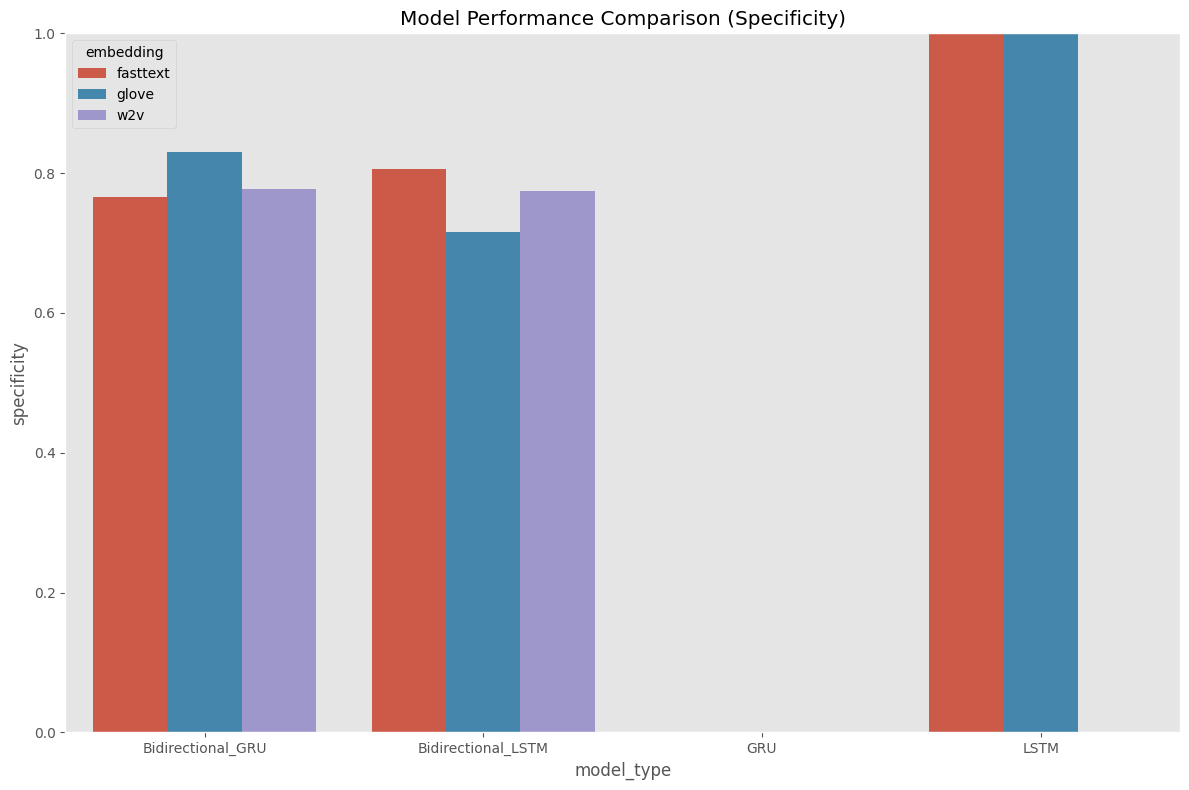

In [44]:
# Define comprehensive testing configurations
configurations = [
    # LSTM configurations with different embeddings
    {
        'model_type': 'LSTM',
        'embedding': 'w2v',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'LSTM',
        'embedding': 'fasttext',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'LSTM',
        'embedding': 'glove',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },

    # Bidirectional_LSTM configurations
    {
        'model_type': 'Bidirectional_LSTM',
        'embedding': 'w2v',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'Bidirectional_LSTM',
        'embedding': 'glove',  # GloVe often works well with bidirectional models
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'Bidirectional_LSTM',
        'embedding': 'fasttext',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'GRU',
        'embedding': 'w2v',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'GRU',
        'embedding': 'fasttext',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'GRU',
        'embedding': 'glove',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 5,
        'batch_size': 32
    },

    {
        'model_type': 'Bidirectional_GRU',
        'embedding': 'w2v',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'Bidirectional_GRU',
        'embedding': 'fasttext',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'Bidirectional_GRU',
        'embedding': 'glove',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },

    # # RNN configurations
    # {
    #     'model_type': 'RNN',
    #     'embedding': 'w2v',
    #     'embedding_dim': 100,
    #     'lstm_units': 128,
    #     'max_length': 100,
    #     'epochs': 5,
    #     'batch_size': 32
    # },
    # {
    #     'model_type': 'RNN',
    #     'embedding': 'fasttext',
    #     'embedding_dim': 100,
    #     'lstm_units': 128,
    #     'max_length': 100,
    #     'epochs': 5,
    #     'batch_size': 32
    # }
]

# Function to run multiple experiments
def run_experiments(configurations, document, labels):
    """
    Run experiments for all configurations.

    Args:
        configurations: List of configuration dictionaries
        document: Text data
        labels: Target labels
    """
    results = []

    # Make sure all existing MLflow runs are closed before starting new ones
    try:
        mlflow.end_run()
    except:
        pass

    for i, config in enumerate(configurations):
        print(f"\n[{i+1}/{len(configurations)}] Testing {config['model_type']} with {config['embedding']} embeddings")

        # Create run name
        run_name = f"{config['model_type']}_{config['embedding']}_{config['epochs']}epochs"

        try:
            with mlflow.start_run(run_name=run_name, nested=False):
                # Initialize model
                model = NeuralTweetClassifier(
                    embedding=config['embedding'],
                    embedding_dim=config['embedding_dim'],
                    lstm_units=config['lstm_units'],
                    max_length=config['max_length'],
                    model_type=config['model_type']
                )

                # Train and evaluate
                print(f"Training {config['model_type']} with {config['embedding']} embeddings...")
                metrics = model.fit(
                    text=document,
                    labels=labels,
                    epochs=config['epochs'],
                    batch_size=config['batch_size']
                )

                # Log configuration details
                mlflow.log_param("config_number", i+1)

                # Add to results
                result = {
                    'config': config,
                    'metrics': metrics,
                    'run_name': run_name
                }
                results.append(result)

                print(f"Completed {run_name}")

        except Exception as e:
            print(f"Error in experiment {run_name}: {e}")
            continue

    return results

# Run all experiments
experiment_name = "P7-Sentiments_Analysis_neural_network"
mlflow.set_experiment(experiment_name)

# Clean data if needed
clean_df = sample_df.dropna(subset=['text', 'target'])
document = clean_df["text"]
labels = clean_df["target"]

# Run experiments
experiment_results = run_experiments(configurations, document, labels)

# Create a summary of results
summary_rows = []
for result in experiment_results:
    config = result['config']
    metrics = result['metrics']

    # Extract test metrics
    test_metrics = metrics.get('test', {})

    row = {
        'model_type': config['model_type'],
        'embedding': config['embedding'],
        'accuracy': test_metrics.get('accuracy', None),
        'specificity': test_metrics.get('specificity', None),
        'f1_score': test_metrics.get('f1_score', None),
        'precision': test_metrics.get('precision', None),
        'recall': test_metrics.get('recall', None),
        'roc_auc': test_metrics.get('roc_auc', None)
    }
    summary_rows.append(row)

# Create summary dataframe
summary_df = pd.DataFrame(summary_rows)
print("\n=== Experiment Results Summary ===")
print("Available columns:", summary_df.columns.tolist())
if not summary_df.empty:
    print("Sample values:", summary_df.iloc[0].to_dict())
display(summary_df.sort_values(by=['accuracy', 'specificity'], ascending=False))

# Visualize results
plt.figure(figsize=(12, 8))

# Group by model type and embedding
grouped_results = summary_df.groupby(['model_type', 'embedding'])['specificity'].mean().reset_index()
sns.barplot(x='model_type', y='specificity', hue='embedding', data=grouped_results)
plt.title('Model Performance Comparison (Specificity)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('model_comparison_summary.png')
mlflow.log_artifact('model_comparison_summary.png', artifact_path="summaries")
plt.show()

In [ ]:
def find_best_model():
    """
    Find the best performing models across multiple metrics in the current experiment.

    Returns:
        dict: Dictionary mapping metrics to information about the best run
    """
    # Get all runs for this experiment
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

    if runs.empty:
        print("No runs found in the experiment.")
        return {}

    # Print available columns for debugging
    print("Available columns in MLflow runs:")
    print(runs.columns.tolist())

    # Filter runs that have valid parameter values (exclude parent runs)
    valid_runs = runs[runs['params.model_type'].notna() & runs['params.embedding'].notna()]

    if valid_runs.empty:
        print("No runs with valid model parameters found.")
        return {}

    print(f"Found {len(valid_runs)} valid runs with model parameters.")

    # Filter for metrics we're interested in
    best_models = {}
    metrics_to_check = ['test_f1_score', 'test_accuracy', 'test_roc_auc', 'test_specificity']

    for metric in metrics_to_check:
        metric_col = f'metrics.{metric}'

        if metric_col in valid_runs.columns:
            # Check if there are any non-null values for this metric
            metric_runs = valid_runs[valid_runs[metric_col].notna()]

            if not metric_runs.empty:
                # Find the index of the maximum value
                best_idx = metric_runs[metric_col].idxmax()
                best_run = metric_runs.loc[best_idx]

                # Create entry for this best model
                best_models[metric] = {
                    'run_id': best_run['run_id'],
                    'run_name': best_run['tags.mlflow.runName'] if 'tags.mlflow.runName' in best_run else 'unnamed',
                    'value': best_run[metric_col],
                    'model_type': best_run['params.model_type'],
                    'embedding': best_run['params.embedding']
                }

                # Add additional metrics if available
                for additional_metric in metrics_to_check:
                    additional_col = f'metrics.{additional_metric}'
                    if additional_col in best_run and additional_metric != metric:
                        best_models[metric][additional_metric] = best_run[additional_col]
            else:
                print(f"No valid values found for metric: {metric}")
        else:
            print(f"Metric '{metric}' not found in available columns")

    # Display results
    if best_models:
        print("\n=== Best Models by Metric ===")
        for metric, info in best_models.items():
            print(f"{metric}: {info['model_type']} with {info['embedding']} - {info['value']:.4f}")
    else:
        print("No best models found based on the specified metrics.")

    return best_models

# Find the best models
best_models = find_best_model()

Available columns in MLflow runs:
['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time', 'metrics.val_specificity', 'metrics.val_precision', 'metrics.val_accuracy', 'metrics.val_recall', 'metrics.test_f1_score', 'metrics.test_specificity', 'metrics.test_recall', 'metrics.test_precision', 'metrics.training_time', 'metrics.val_f1_score', 'metrics.val_roc_auc', 'metrics.test_accuracy', 'metrics.test_roc_auc', 'metrics.train_loss', 'metrics.train_accuracy', 'metrics.test_f1', 'metrics.val_loss', 'params.lstm_units', 'params.epochs', 'params.max_length', 'params.config_number', 'params.model_type', 'params.embedding_dim', 'params.local_model_path', 'params.batch_size', 'params.embedding', 'params.model_name', 'params.gradient_accumulation_steps', 'params.learning_rate', 'params.device', 'tags.mlflow.user', 'tags.mlflow.source.type', 'tags.mlflow.source.name', 'tags.mlflow.runName', 'tags.mlflow.parentRunId']
Found 14 valid runs with model parameters.

=== Best Model

Visualization saved and logged to MLflow

=== Top 3 Models Overall ===


,Model Type,Embedding,Accuracy,F1 Score,ROC AUC,Avg Score
0,Bidirectional_LSTM,glove,0.7780,0.790921,0.866969,0.804622
1,Bidirectional_GRU,glove,0.7831,0.772475,0.868251,0.794498
2,Bidirectional_GRU,fasttext,0.7715,0.772931,0.854094,0.788889


Visualization saved and logged to MLflow

=== Top 3 Models Overall ===


,Model Type,Embedding,Accuracy,F1 Score,ROC AUC,Avg Score
0,Bidirectional_LSTM,glove,0.7780,0.790921,0.866969,0.804622
1,Bidirectional_GRU,glove,0.7831,0.772475,0.868251,0.794498
2,Bidirectional_GRU,fasttext,0.7715,0.772931,0.854094,0.788889


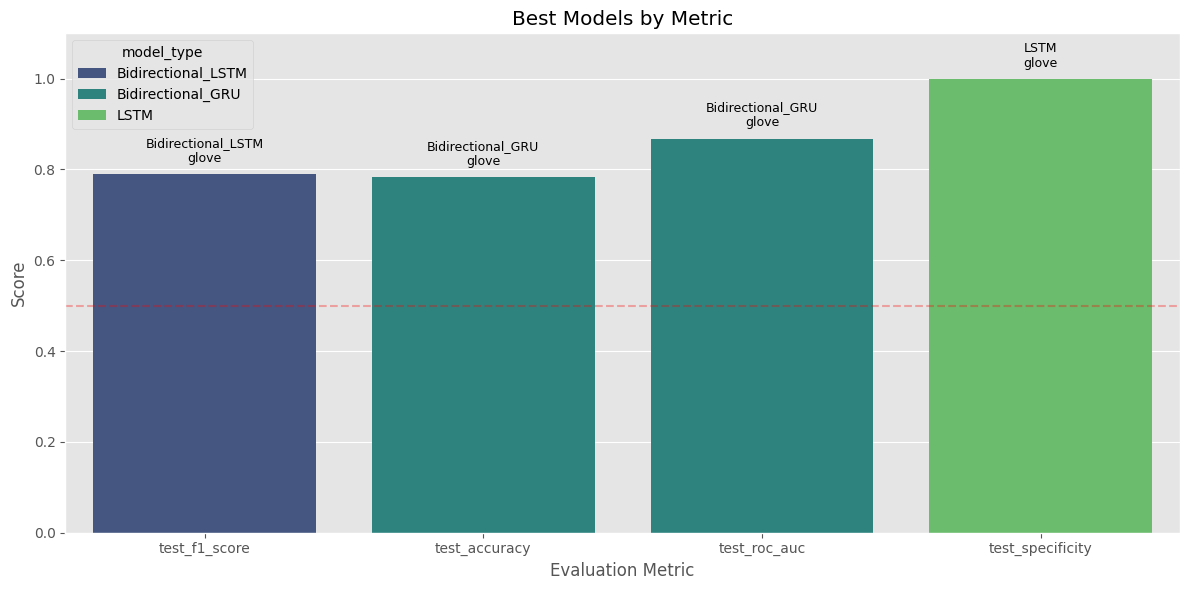

In [46]:
def visualize_best_models(best_models):
    """
    Create a visualization comparing the best models across different metrics.

    Args:
        best_models: Dictionary returned by find_best_model()
    """
    if not best_models:
        print("No models to visualize.")
        return

    # Create dataframe for visualization
    rows = []
    for metric, info in best_models.items():
        rows.append({
            'metric': metric,
            'model_type': info['model_type'],
            'embedding': info['embedding'],
            'value': info['value']
        })

    vis_df = pd.DataFrame(rows)

    # Plot
    plt.figure(figsize=(12, 6))

    # Create grouped bar chart
    sns.barplot(x='metric', y='value', hue='model_type', data=vis_df, palette='viridis')

    # Add model types and embeddings as text annotations
    for i, row in enumerate(rows):
        plt.text(i, row['value'] + 0.02,
                 f"{row['model_type']}\n{row['embedding']}",
                 ha='center', va='bottom', rotation=0,
                 fontsize=9, color='black')

    plt.title('Best Models by Metric')
    plt.xlabel('Evaluation Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)

    # Add a horizontal line at 0.5 for reference
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)

    plt.tight_layout()

    # Save figure
    plt.savefig('../artifacts/best_models_comparison.png')
    try:
        mlflow.log_artifact('../artifacts/best_models_comparison.png', artifact_path="model_comparison")
        print("Visualization saved and logged to MLflow")
    except Exception as e:
        print(f"Couldn't log to MLflow: {e}")

    return plt

# Visualize the best models
visualize_best_models(best_models)

# Additional analysis: Let's create a table summarizing the top 3 models overall
def summarize_top_models():
    """
    Create a summary table of the top 3 models based on average performance across metrics.
    """
    # Get all runs with valid parameters
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    valid_runs = runs[runs['params.model_type'].notna() & runs['params.embedding'].notna()]

    if valid_runs.empty:
        print("No valid runs found for summary")
        return

    # Calculate average performance across important metrics
    metrics = ['metrics.test_accuracy', 'metrics.test_f1_score',
               'metrics.test_roc_auc', 'metrics.test_precision',
               'metrics.test_recall']

    # Get only runs that have all metrics
    complete_runs = valid_runs.dropna(subset=metrics)

    if complete_runs.empty:
        print("No runs with complete metrics found")
        return

    # Calculate average score
    complete_runs['avg_score'] = complete_runs[metrics].mean(axis=1)

    # Get top 3
    top_runs = complete_runs.sort_values('avg_score', ascending=False).head(3)

    # Create summary table
    summary_table = pd.DataFrame({
        'Model Type': top_runs['params.model_type'],
        'Embedding': top_runs['params.embedding'],
        'Accuracy': top_runs['metrics.test_accuracy'],
        'F1 Score': top_runs['metrics.test_f1_score'],
        'ROC AUC': top_runs['metrics.test_roc_auc'],
        'Avg Score': top_runs['avg_score']
    })

    print("\n=== Top 3 Models Overall ===")
    display(summary_table.reset_index(drop=True))

    return summary_table

# Show summary of top models
top_models = summarize_top_models()